<h1 align='center'> Monte-Carlo (MCMC) - TP6 (Homework due April 28 23h59) </h1>
<h4 align='right'><i> author: GRIMAUD </i></h4>


In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

import time
import scipy.integrate as integrate
from scipy.stats import norm

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.



1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

In [ ]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)

In [ ]:
#Find an empirical bound M

M, m = 1,1

for val in x:
  m = f(val)/g(val)
  if m>M:
    M=m

print('The empirical bound M found is '+str(M))

The empirical bound M found is 2.1652254894455245


*Now we are going to visualize the domination of f by Mg.*

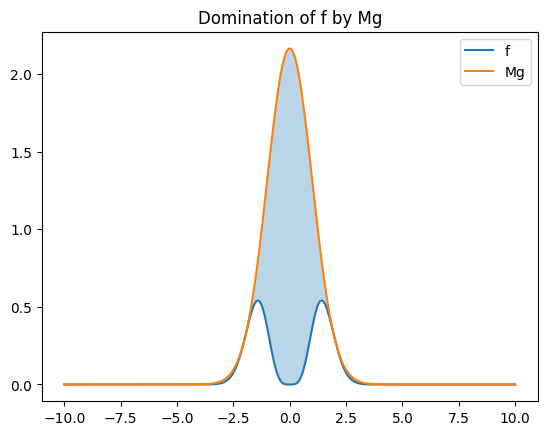

In [ ]:
plt.plot(x, f(x), label='f')
plt.plot(x,M*g(x), label='Mg')
plt.title('Domination of f by Mg')
plt.fill_between(x, f(x), M*g(x), where=f(x) <= M*g(x), interpolate=True, alpha=0.3)
plt.legend()
plt.show()

2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

In [ ]:
#Firstly, let's determine the normalizing constant of f
F = integrate.quad(f, -np.inf, np.inf)[0]
print(F)

1.3293403881791368


In [ ]:
def rejection_sampling(n=1000, f=f, g=g, M=M, N=10000):
    """Reject sampling algorithm for f with Gaussian proposal g."""
    start = time.time()
    samples = []
    while len(samples)<N:

        y = norm.ppf(np.random.uniform(0,1,n)) #ppf is the inverse of Gaussian
        u = np.random.uniform(0,1,n)

        indices = np.where(u<=f(y)/(M*g(y)))
        samples.extend(y[indices])
    end = time.time()
    return samples, x, start, end, N



Computational time of Rejection Sampling algorithm : 0.021440505981445312 seconds


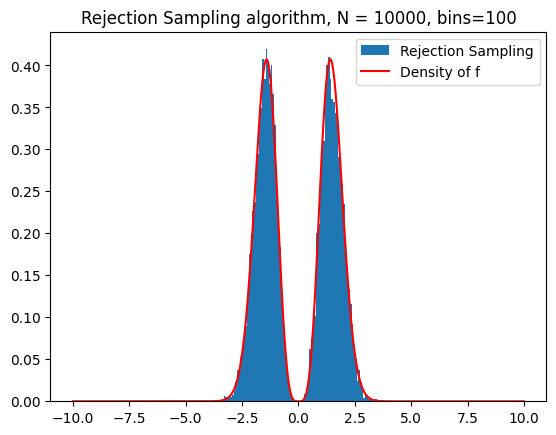

In [ ]:
samples, x, start, end, N = rejection_sampling()
bins=100

plt.hist(samples, density=1, bins=100, label='Rejection Sampling')
plt.plot(x,f(x)/F,label='Density of f', c='r')
plt.title('Rejection Sampling algorithm, N = '+str(N)+', bins='+str(bins))
plt.legend()
print('Computational time of Rejection Sampling algorithm : '+str(end-start)+' seconds')
plt.show()

*So, the rejection sampling algorithm seems to work, as it's matching the of f curve. Moreover, as we implemented also a calculation time, we can observe that the final result is fast.*

3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

In [ ]:
def rw_metropolis_hastings(n, f=f, bins=50, seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """
    start = time.time()
    np.random.seed(seed)
    x0 = np.random.uniform(-1,1)
    samples = [x0]
    fx = f(x0)
    while len(samples) < n:
        x_ = x0 + np.random.normal()
        fx_ = f(x_)
        alpha = fx_/fx
        if alpha>= 1:
            x0 = x_
            fx = fx_
        uni_ = np.random.uniform(0,1)
        if uni_ <= alpha:
            x0 = x_
            fx = fx_
        samples.append(x0)

    end = time.time()
    plt.hist(samples, density=1, bins = bins, label='Metropolis Hastings Method')
    plt.plot(x,f(x)/F,label='Goal : density of f', c='r')
    plt.title('Low Quality Metropolis Hastings algorithm, n = '+str(n)+', bins='+str(bins))
    plt.legend()
    print('Computational time of low quality Metropolis Hastings method : '+str(end-start)+' seconds')
    return plt.show()



*Let's first visualize the result for a small number of samples, such that a low quality method, then we will increase the number of samples*

Computational time of low quality Metropolis Hastings method : 0.006869316101074219 seconds


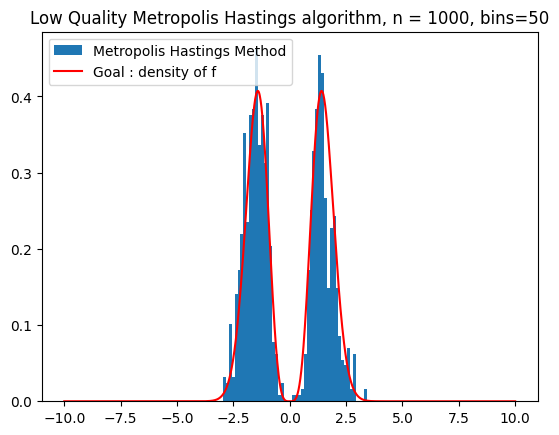

Computational time of low quality Metropolis Hastings method : 0.06267976760864258 seconds


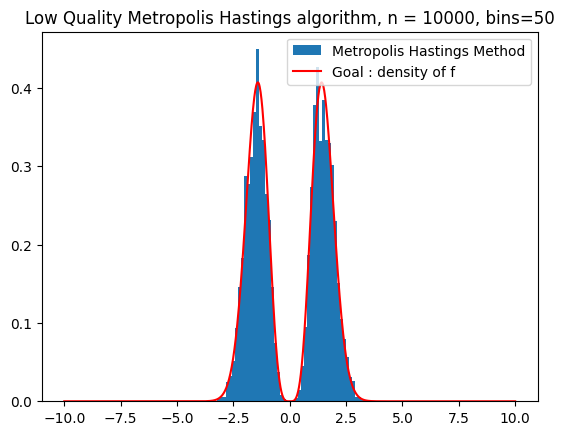

Computational time of low quality Metropolis Hastings method : 5.6010730266571045 seconds


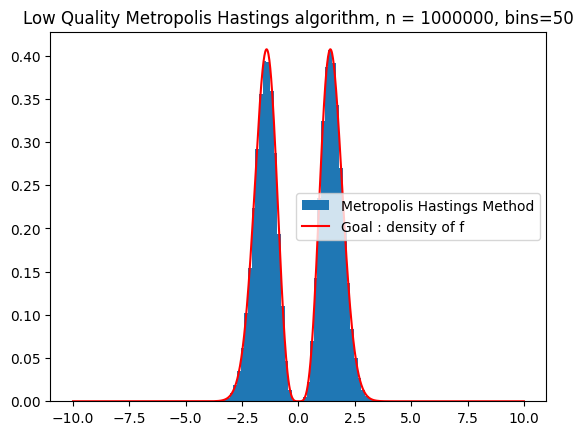

In [ ]:
rw_metropolis_hastings(n=1000)
rw_metropolis_hastings(n=10000)
rw_metropolis_hastings(n=1000000)

Computational time of low quality Metropolis Hastings method : 6.3565332889556885 seconds


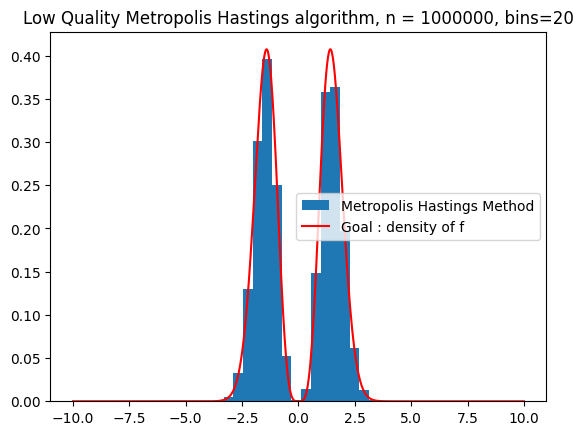

In [ ]:
rw_metropolis_hastings(n=1000000, bins=20)

*Finally, we observe that increasing to 1000000 samples worth it, because lower number of samples seems not sufficient. Moreover, the rw_metropolis_hastings algorithm seems faster thant the previous one.*

# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

The density of a two dimensional Gaussian variable is:
$$
  p(x_1,x_2) = \frac{1}{2\pi \sqrt{\lvert det(\Sigma)\rvert}}e^{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)}
$$
where $\Sigma$ typically denotes the covariance matrix such that, in the symmetric case, $ \Sigma^{-1}=\frac{1}{1-\rho^2} \begin{bmatrix} 1 & -\rho \\ -\rho & 1 \end{bmatrix} $ and the mean vector $\mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$.

Therefore the multivariate Gaussian follows:
$$
(X_1,X_2) \sim \mathcal{N}(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} )
$$

Secondly, let's compute the conditional density $p(x_2|x_1)$, which is the same as $p(x_1|x_2)$ as the problem is symmetric. Using Bayes formula, we have:
$$
p(x_2|x_1) = \frac{p(x_1,x_2)}{p(x_1)} = \frac{\frac{1}{2\pi\sqrt{1-\rho^2}}e^{- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)}}{\frac{1}{\sqrt{2\pi}}e^{-\frac{x_1^2}{2}}} = \frac{1}{\sqrt{2\pi (1-\rho^2)}} e^{-\frac{(x_2-\rho x_1)^2}{2(1-\rho^2)}}
$$
So, by identification, $X_2|(X_1=x_1) \sim \mathcal{N} (\rho x_1, 1-\rho^2)$

The results are symmetric, so:
$$
 p(x_1|x_2) = \frac{1}{\sqrt{2\pi (1-\rho^2)}} e^{-\frac{(x_1-\rho x_2)^2}{2(1-\rho^2)}}~and~X_1|(X_2=x_2) \sim \mathcal{N} (\rho x_2, 1-\rho^2)
$$


*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [ ]:
def gibbs_sampler(n=10000, rho=0.7):
    """Gibbs sampler for (X_1, X_2)."""
    X = []
    x1,x2=0,0
    for i in range(int(n)):
      x1 = np.random.normal(rho*x2, 1-rho**2)
      x2 = np.random.normal(rho*x1, 1-rho**2)
      X.append([x1,x2])
    return X

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

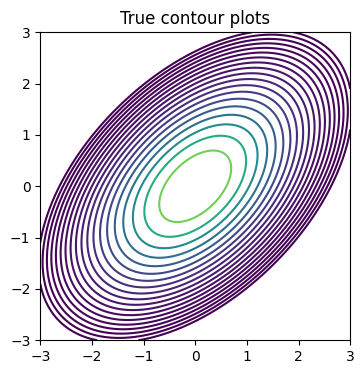

In [ ]:
from scipy.stats import multivariate_normal
rho = 0.5
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(4, 4))
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")
plt.show()

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

In [ ]:
def plot_4(npow=6, rho=0.5, bins=1000, gibbs_sampler=gibbs_sampler):
    iter = np.floor(np.logspace(1,npow,4))
    fig, ax = plt.subplots(1,4,figsize=(20,4))
    for i in range(4):
        samples = np.array(gibbs_sampler(iter[i],rho))
        E, x, y = np.histogram2d(samples[:,0],samples[:,1],bins=bins,density=True)
        ax[i].contourf(x[1:], y[1:], E) #contourf is more precise than contour
        ax[i].set_title('Plot after '+str(iter[i])+' iterations')
    return plt.show()

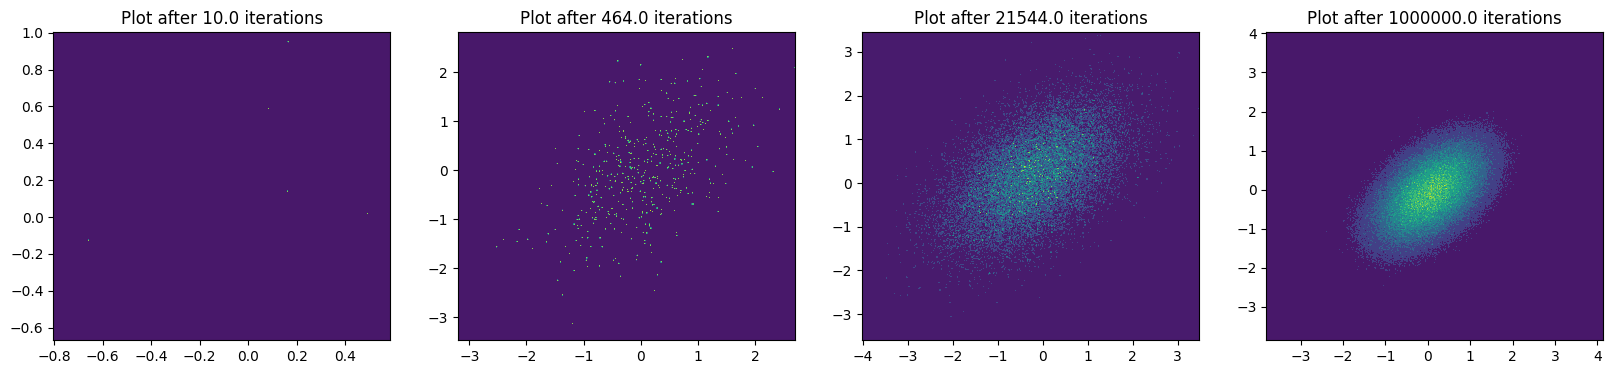

In [ ]:
plot_4()



*In spite of the imperfection of the final plot, we can recognize the target distribution, observing the center and the inclination of it. We could increase the number of iterations, but the computational time could make it not worthable.*

*Finally, unsurprisingly, the approximation gets better as the number of iterations grows.*

*Now we are comparing the results depending on the value of $\rho$*

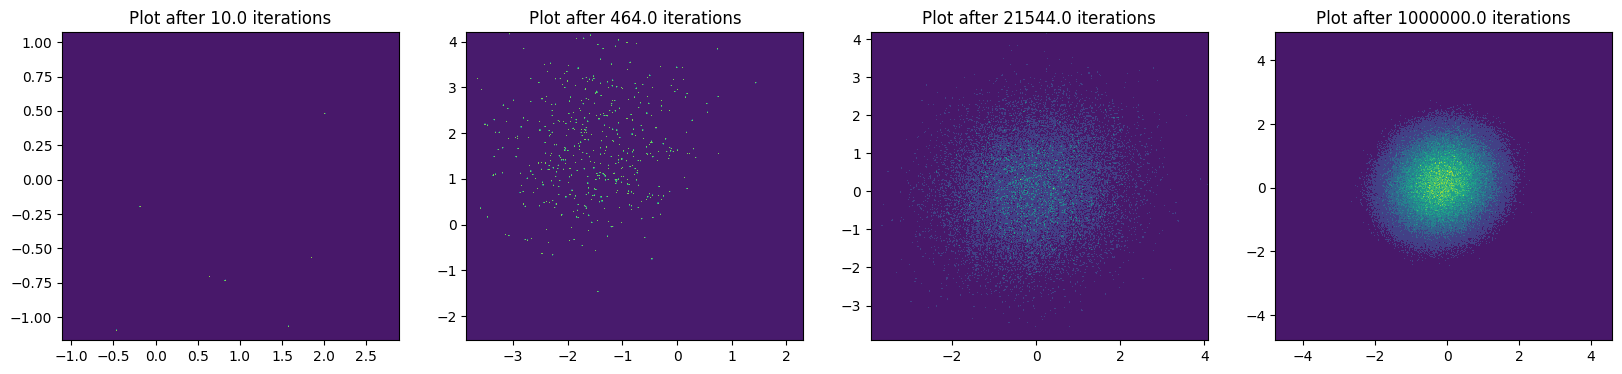

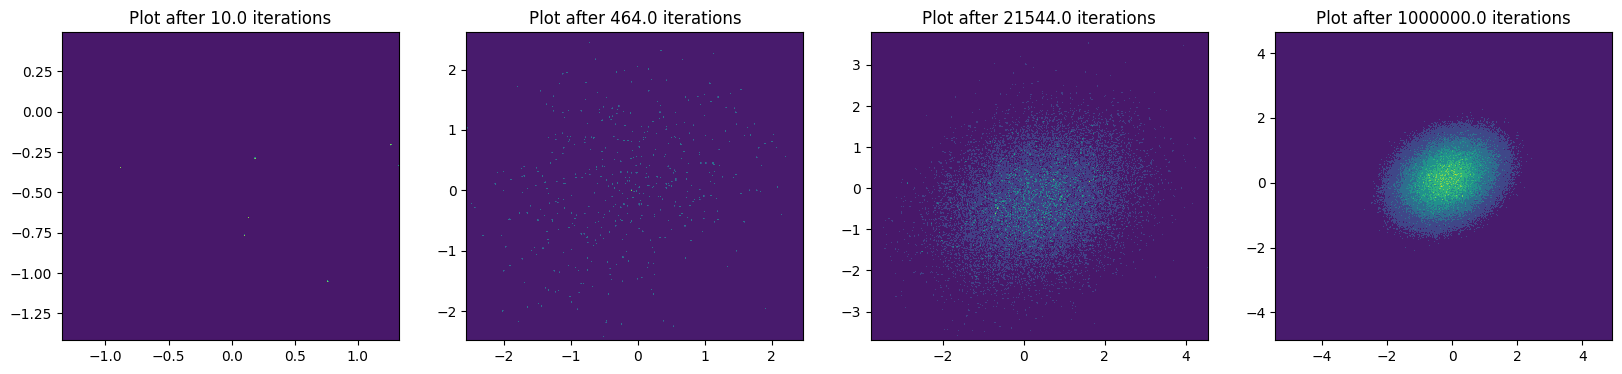

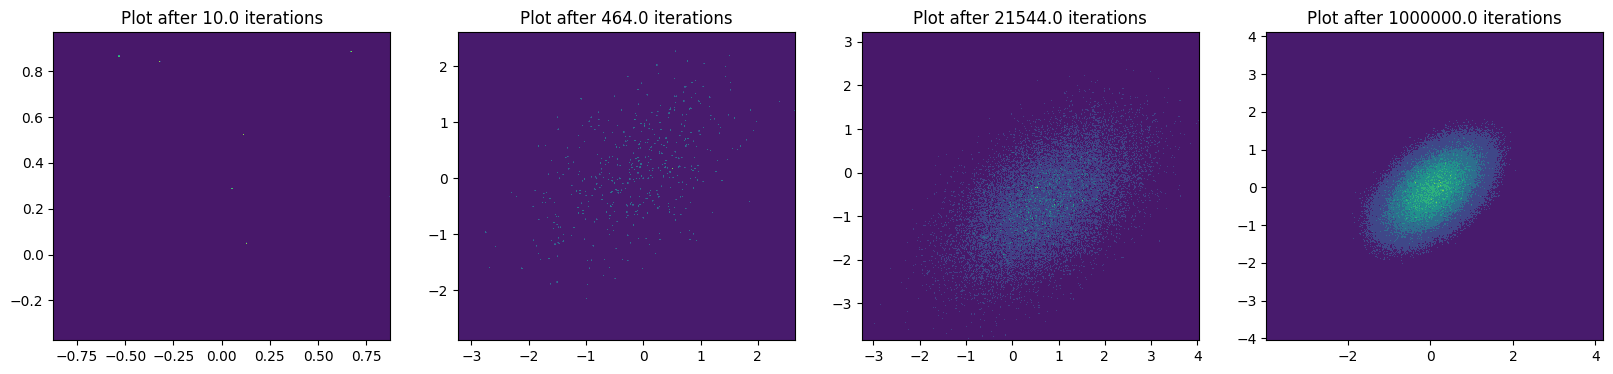

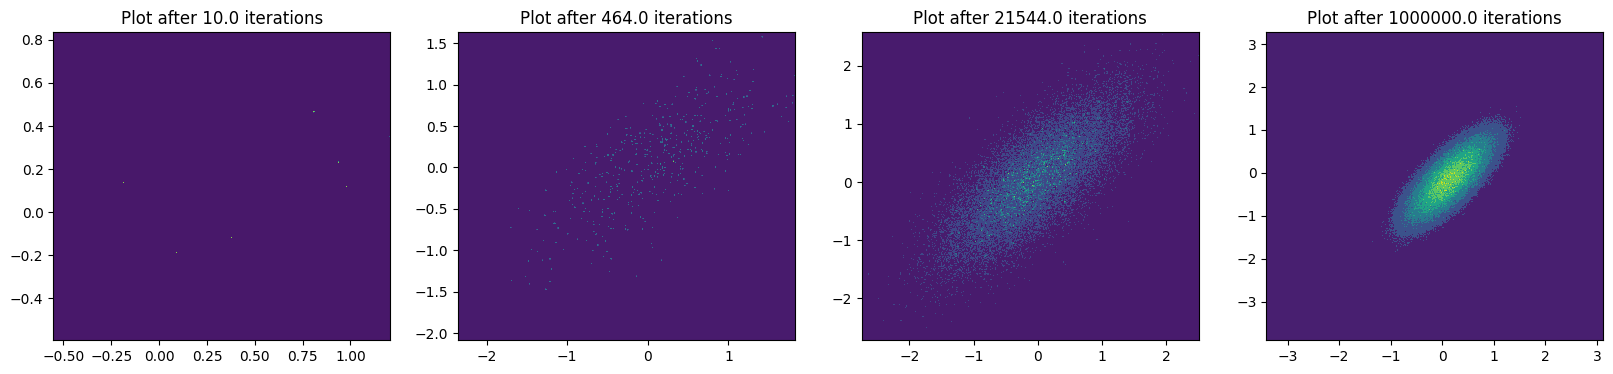

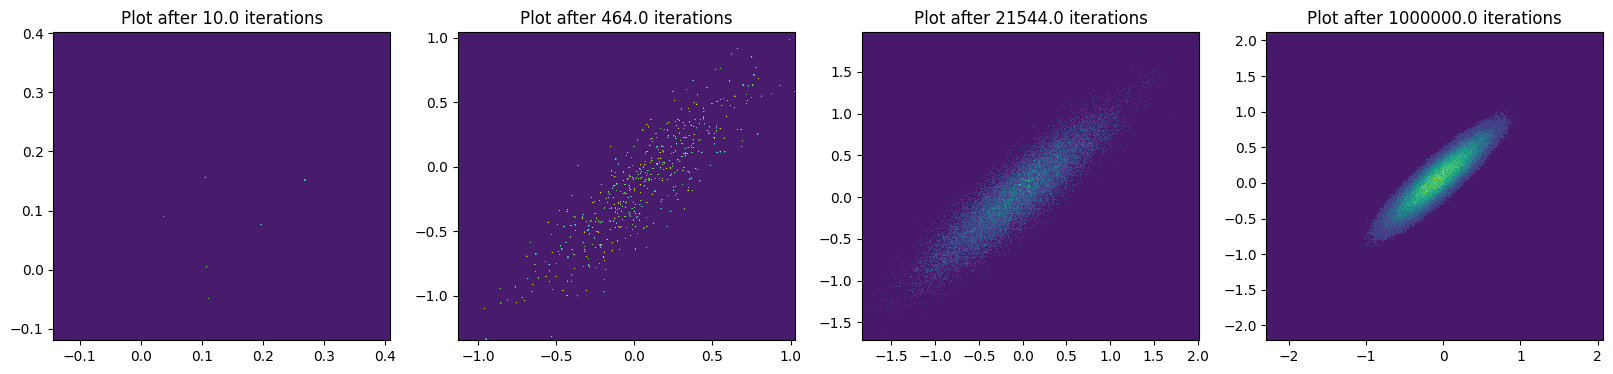

In [ ]:
plot_4(rho=0.1)
plot_4(rho=0.25)
plot_4(rho=0.5)
plot_4(rho=0.75)
plot_4(rho=0.9)



*As the value of $\rho$ increases, the correlation between the data points becomes stronger and stronger. Eventually, we can observe that when $\rho \rightarrow 1$, the data points form a straight line (QUESTION 5).*

4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

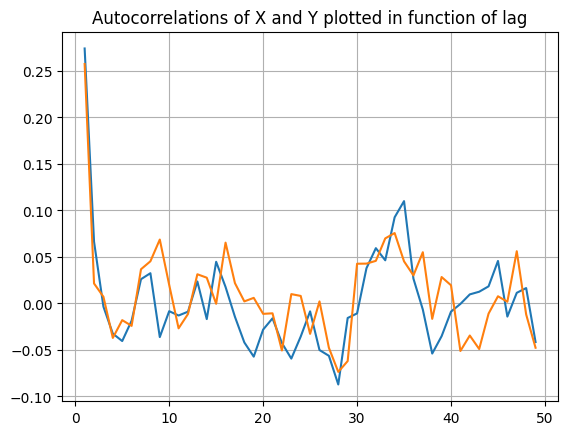

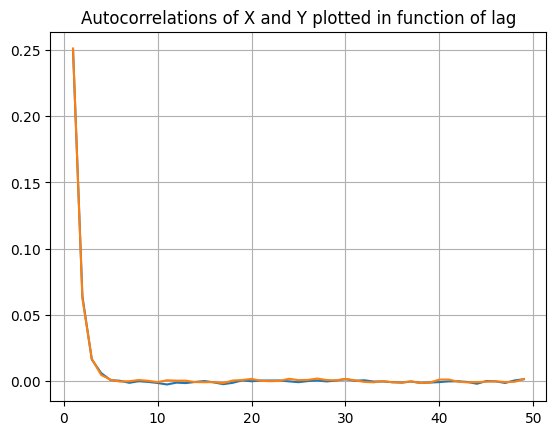

In [ ]:
def autocorr(N=100000, gibbs_sampler=gibbs_sampler, maxlag=50, rho=0.5):
    samples = np.array(gibbs_sampler(N, rho))
    lagList = np.array(range(1, maxlag))
    x_corr = []
    y_corr = []
    for curLag in lagList:
        corr = np.corrcoef(samples[curLag:, :], samples[:-curLag, :], rowvar=False)
        x_corr.append(corr[0, 2])
        y_corr.append(corr[1, 3])

    plt.plot(lagList, x_corr, label='X autocorr')
    plt.plot(lagList, y_corr, label='Y autocorr')
    plt.grid()
    plt.title('Autocorrelations of X and Y plotted in function of lag')
    return plt.show()

# Run the autocorr function
autocorr(N=1000)
autocorr(N=1000000)

*We observe that the auto-correlation decrease to zero after approximately the fourth lag, which means that the effect of autocorrelation vanishes. Therefore we should select only one in 4 samples in order to limit the auto-correlation effect.*

*Moreover, increasing $N$ decreases the variations of autocorrelation in function of lag.*

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

*Here are two arguments that we could add to our Gibbs sampler function to improve the simulation:*

**Burn-in argument:** *We could add a burn_in argument to our Gibbs sampler function to allow the user to specify the number of initial samples to discard. This can help reduce the impact of the initial values on the final results of the simulation. By discarding the first few samples, we can ensure that the remaining samples are more representative of the target distribution.*

In [ ]:
def gibbs_sampler_burn(n=10000, rho=0.7, burn_in=100):
    """Gibbs sampler for (X_1, X_2)."""
    X = []
    x1,x2 = 0,0
    for i in range(int(n + burn_in)):
        x1 = np.random.normal(rho*x2, 1-rho**2)
        x2 = np.random.normal(rho*x1, 1-rho**2)
        if i >= burn_in:
            X.append([x1,x2])
    return X

**Thinning argument:** *Moreover, we could add a thinning argument to our Gibbs sampler function to allow the user to specify the interval between recorded samples. This can help reduce the autocorrelation between consecutive samples (because the closer two samples are to each other, the higher their correlation) and obtain a more representative sample from the target distribution in order to improve the quality of the simulation.*

In [ ]:
def gibbs_sampler_combined(n=10000, rho=0.7, burn_in=100, thinning=10):
    """Gibbs sampler for (X_1, X_2)."""
    X = []
    x1,x2 = 0,0
    for i in range(int((n + burn_in) * thinning)):
        x1 = np.random.normal(rho*x2, 1-rho**2)
        x2 = np.random.normal(rho*x1, 1-rho**2)
        if i >= burn_in * thinning and i % thinning == 0:
            X.append([x1,x2])
    return X

*The final Gibbs sampler generates n + burn_in pairs of x1 and x2 values. The first burn_in pairs of values are discarded and only one out of every thinning pairs of values is recorded.*

*Finally, this can help improve the quality of the simulation by reducing the impact of the initial values and reducing the autocorrelation between consecutive samples.*

**Results**

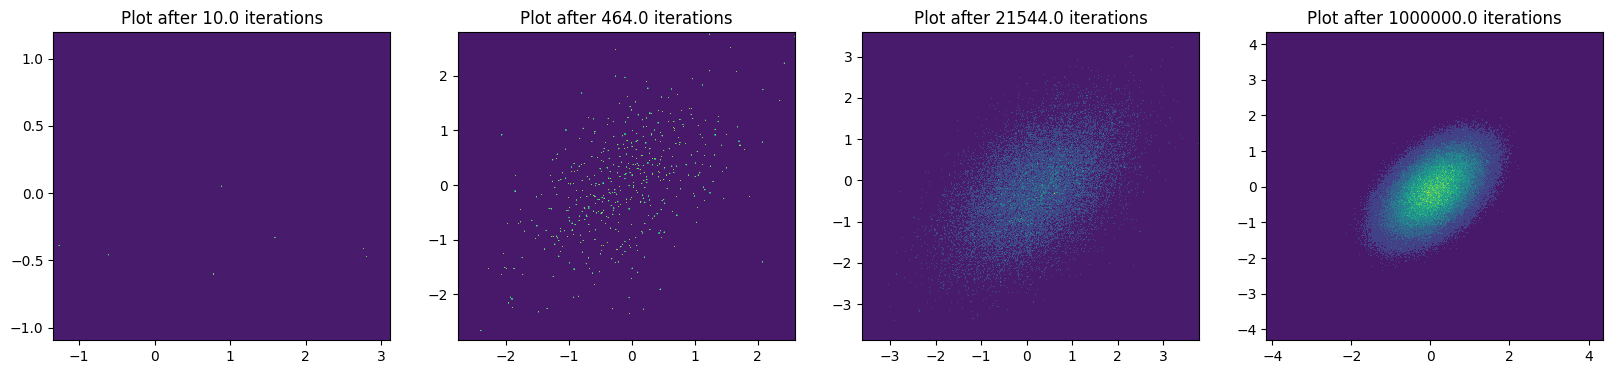

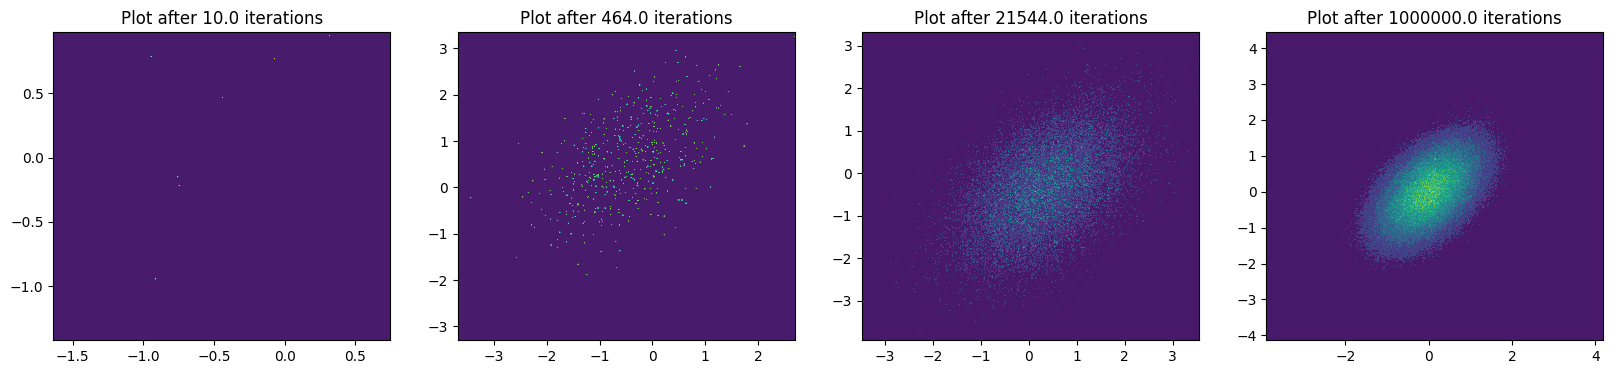

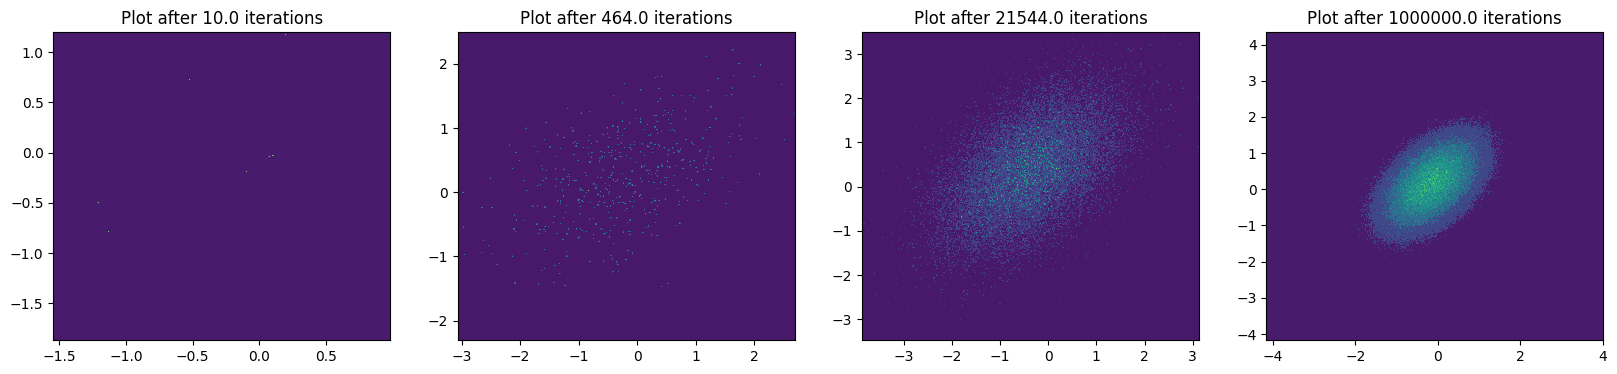

In [ ]:
plot_4(gibbs_sampler=gibbs_sampler)
plot_4(gibbs_sampler=gibbs_sampler_burn)
plot_4(gibbs_sampler=gibbs_sampler_combined)


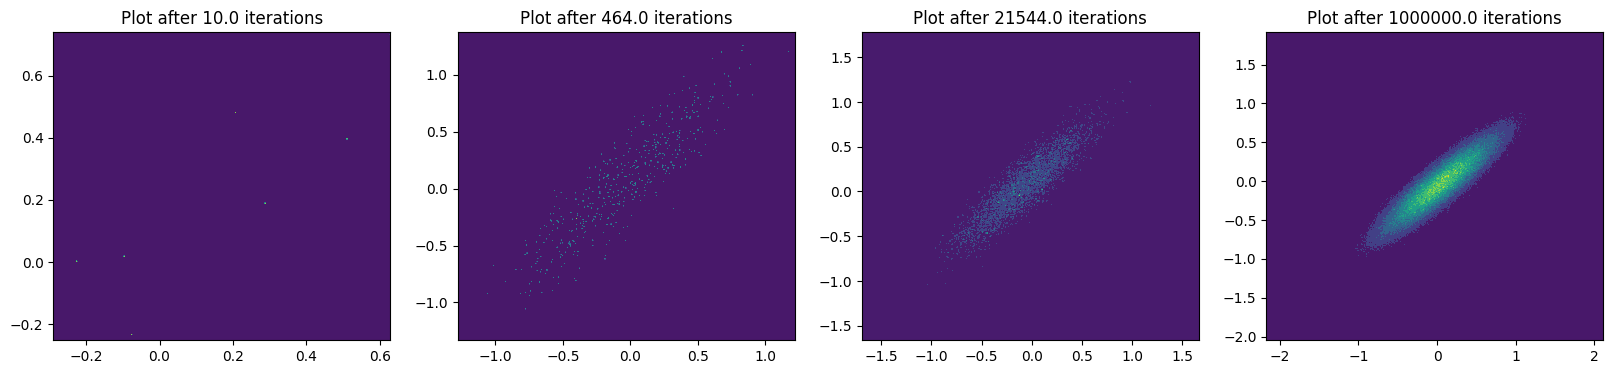

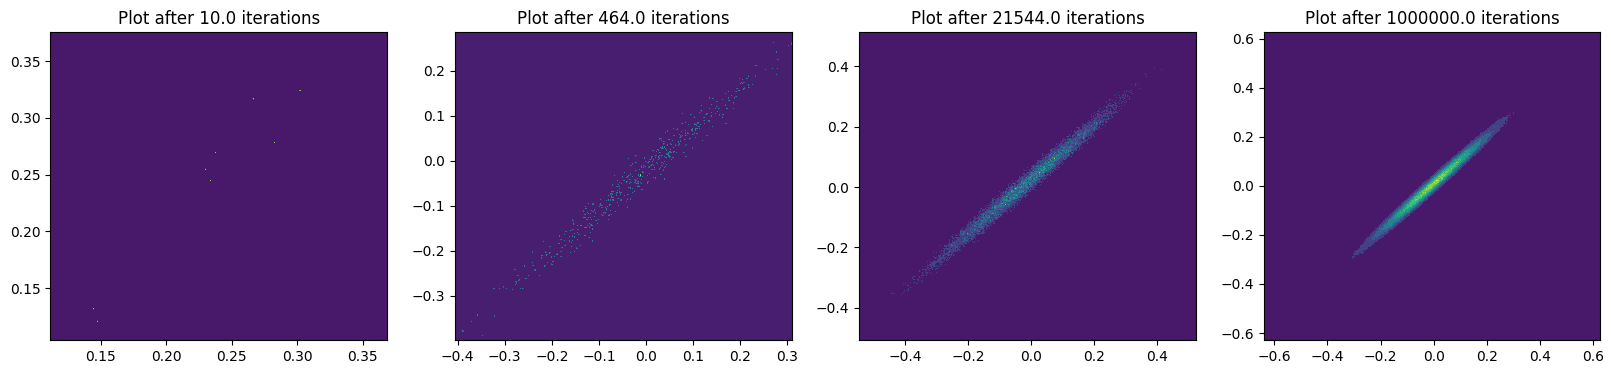

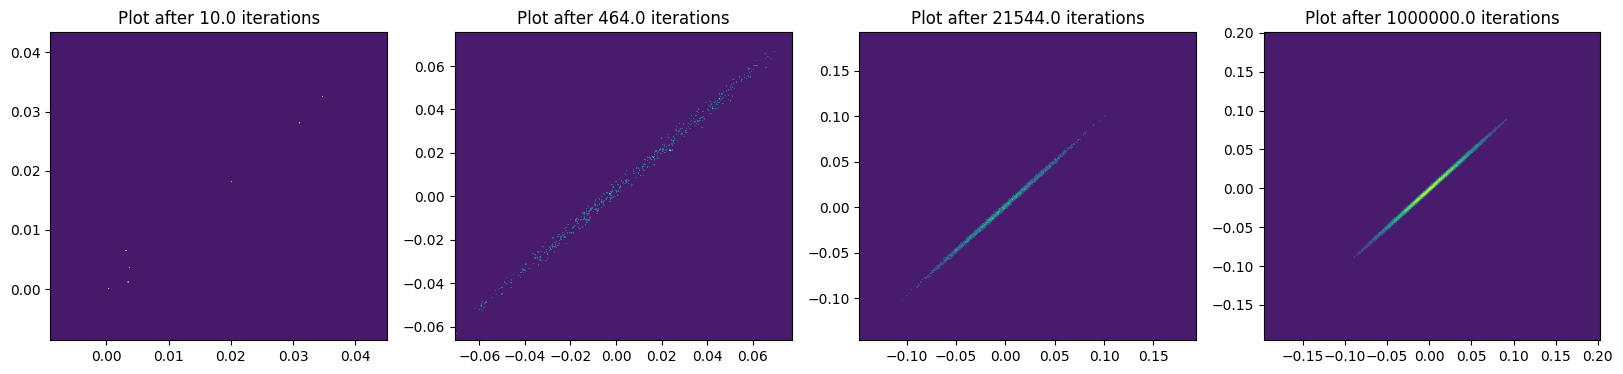

In [ ]:
plot_4(rho=0.9, gibbs_sampler=gibbs_sampler_combined)
plot_4(rho=0.99, gibbs_sampler=gibbs_sampler_combined)
plot_4(rho=0.999, gibbs_sampler=gibbs_sampler_combined)

*As for what happens when $\rho \to 1$, as $\rho$ approaches 1, the conditional variances of $X_1$ and $X_2$ given the other variable approach 0. This means that $X_1$ and $X_2$ become more strongly correlated and more similar to each other. As a result, it may take longer for the Gibbs sampler to converge to the target distribution and we may need to increase the burn_in and thinning parameters to obtain reliable results.*

*As $\rho$ approaches 1, the covariance matrix $\Sigma$ becomes nearly rank-1. This causes the multivariate Gaussian distribution to become elongated in one direction. The conditional distributions of $X_1$​ and $X_2$​ become more tightly coupled, making it difficult for the Gibbs sampler to explore the joint distribution. When $\rho=1$, the conditional distributions of $X_1$​ and $X_2$​ are identical and the Gibbs sampler gets stuck on the diagonal line $X_1​=X_2$​.*

*Because when $\rho = 1$, the covariance matrix becomes singular and cannot be inverted. This can cause numerical issues when computing the conditional distributions of $X_1$ and $X_2$.*

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$.

*Here is following how we can implement a Random Walk Metropolis algorithm to simulate from a bivariate normal distribution with mean 0 and covariance matrix $\Sigma$ using a conditional proposal distribution $\mathcal N(0, \tau I_2)$ for multiple $\tau$:*

In [ ]:
def p(x1, x2,rho=rho):
    return np.exp(-(x1**2+x2**2-2*rho*x1*x2) / (2*(1-rho**2))) / (2*np.pi*np.sqrt(1-rho**2))

In [ ]:
def rw_metropolis_hastings(n=100000, rho=rho, f=p, bins=100, tau=1., seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g."""
    start = time.time()
    np.random.seed(seed)
    x1,x2 = 0,0
    samples = []
    for _ in range(n):
        x1_t, x2_t = np.random.multivariate_normal((x1,x2),[[tau,0],[0,tau]])
        alpha = f(x1_t,x2_t, rho=rho)/f(x1,x2, rho=rho)
        if alpha >= 1 or np.random.uniform(0,1) <= alpha:
            x1, x2 = x1_t, x2_t
        samples.append((x1_t,x2_t))
    end = time.time()
    E, x, y = np.histogram2d(np.array(samples)[:,0],np.array(samples)[:,1],bins=bins,density=True)
    plt.contourf(x[1:], y[1:], E)
    plt.title('Random walk Metropolis Hastings for tau='+str(tau))
    print('Time of Metropolis Hastings method : '+str(end-start)+' seconds')
    return plt.show()

**Results of the implementation**

Time of Metropolis Hastings method : 10.210055112838745 seconds


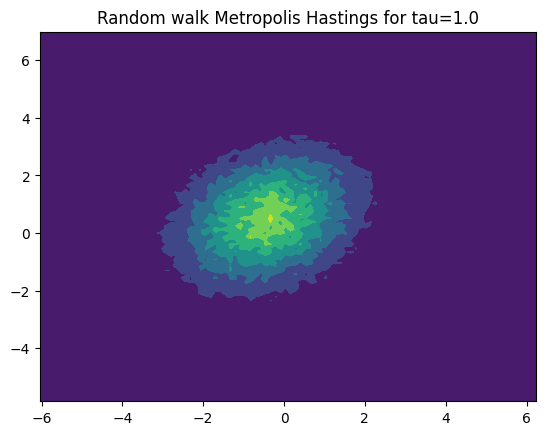

Time of Metropolis Hastings method : 9.698713302612305 seconds


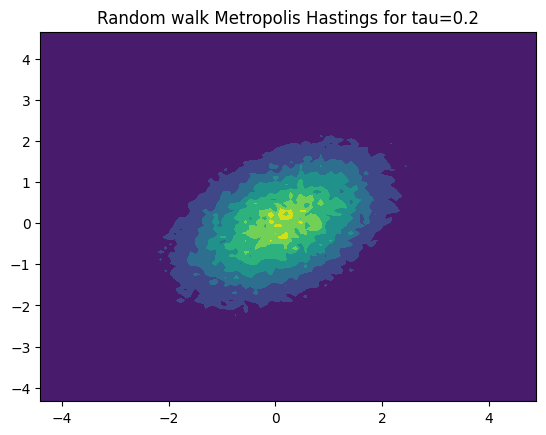

Time of Metropolis Hastings method : 9.551768779754639 seconds


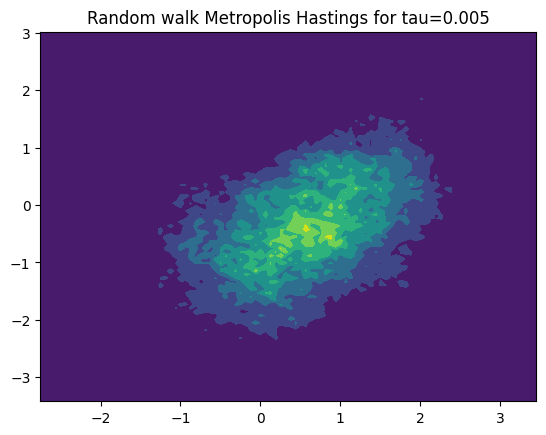

Time of Metropolis Hastings method : 10.169419050216675 seconds


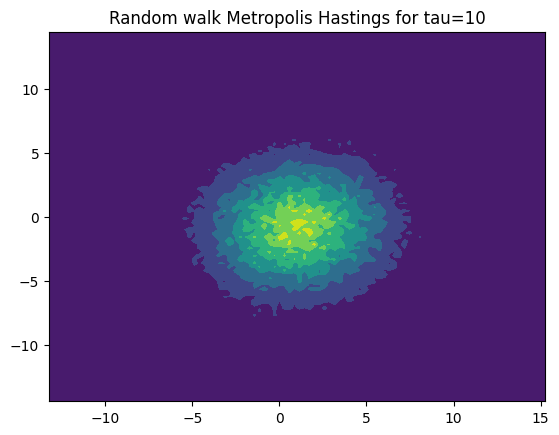

In [ ]:
rho = 0.5
rw_metropolis_hastings(n=100000, rho=rho, f=p, bins=100, tau=1., seed=None)
rw_metropolis_hastings(n=100000, rho=rho, f=p, bins=100, tau=0.2, seed=None)
rw_metropolis_hastings(n=100000, rho=rho, f=p, bins=100, tau=0.005, seed=None)
rw_metropolis_hastings(n=100000, rho=rho, f=p, bins=100, tau=10, seed=None)

*Based on the data and computations done, it is not clear whether a higher value of $\tau$ is better or not. A value of $\tau = 0.2$ produced a good result, but the distribution was less concentrated and may contain more errors. A value of $\tau = 0.005$ was not accurate due to the strong impact of bias and randomness. A value of $τ = 10$ was too large and produced an unrealistic distribution with samples scattered everywhere. As expected, the best results were obtained with values closest to $\tau = 1$.*

*Therefore we can conclude that if the value of $\tau$ is too small, the algorithm will not move much at each iteration and the final distribution will be biased towards the initial values. However, if $\tau$ is too large, the algorithm will become very slow because very few samples will be accepted. The optimal balance appears to be when $\tau$ is equal to 1.*

More precisely:



*When $\tau$ is increased from its usual value of 1, the algorithm takes larger steps and does not stay as focused on interesting areas. This can be problematic for “bumpy” distributions where it is important to thoroughly explore each small region. However, larger steps also allow the algorithm to more easily cross distributions with low probability regions. This is beneficial for distributions with separated probability regions. One downside of increasing $\tau$ is that the algorithm may reject more samples when exploring further regions.*

*On the other hand, when $\tau$ is decreased, the algorithm takes smaller steps and can quickly recover from mistakes. However, it is less likely to cross large low-probability gaps. This can be problematic for certain distributions. One downside of decreasing $\tau$ is that the algorithm may exhibit bias towards the initial point. This can be mitigated by using a large number of samples, but at the cost of increased computational power.*